<a href="https://colab.research.google.com/github/k-dinakaran/chennai-house-price-prediction/blob/main/chennai_house_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   property_id      1000 non-null   int64  
 1   location         1000 non-null   object 
 2   property_type    1000 non-null   object 
 3   sqft             1000 non-null   int64  
 4   bedrooms         1000 non-null   int64  
 5   bathrooms        1000 non-null   int64  
 6   floor            1000 non-null   int64  
 7   total_floors     1000 non-null   int64  
 8   age              1000 non-null   int64  
 9   parking          1000 non-null   int64  
 10  lift             1000 non-null   int64  
 11  metro_distance   1000 non-null   float64
 12  school_distance  1000 non-null   float64
 13  mall_distance    1000 non-null   float64
 14  it_corridor      1000 non-null   int64  
 15  nearby_beach     1000 non-null   int64  
 16  price            1000 non-null   float64
dtyp

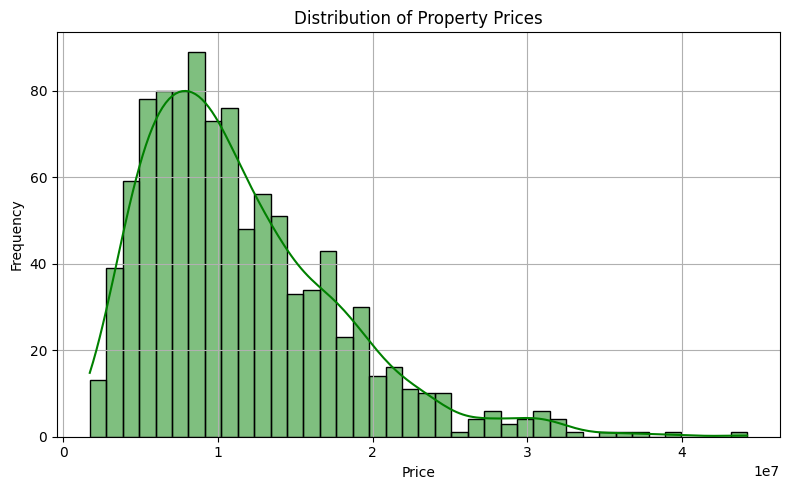

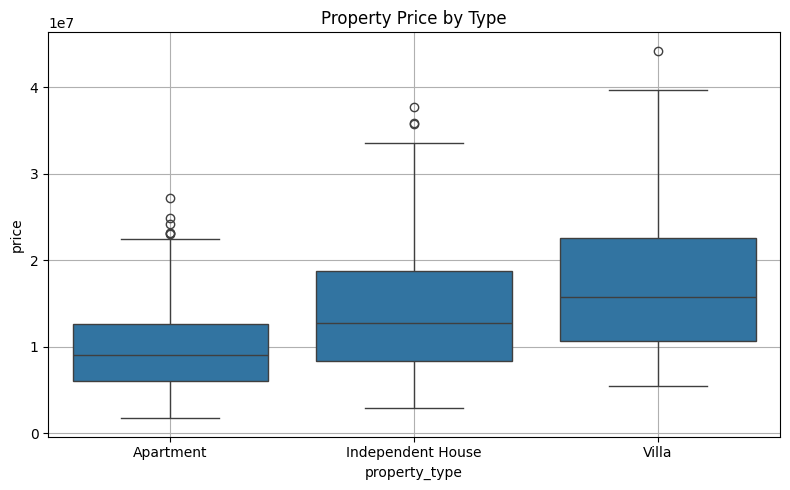

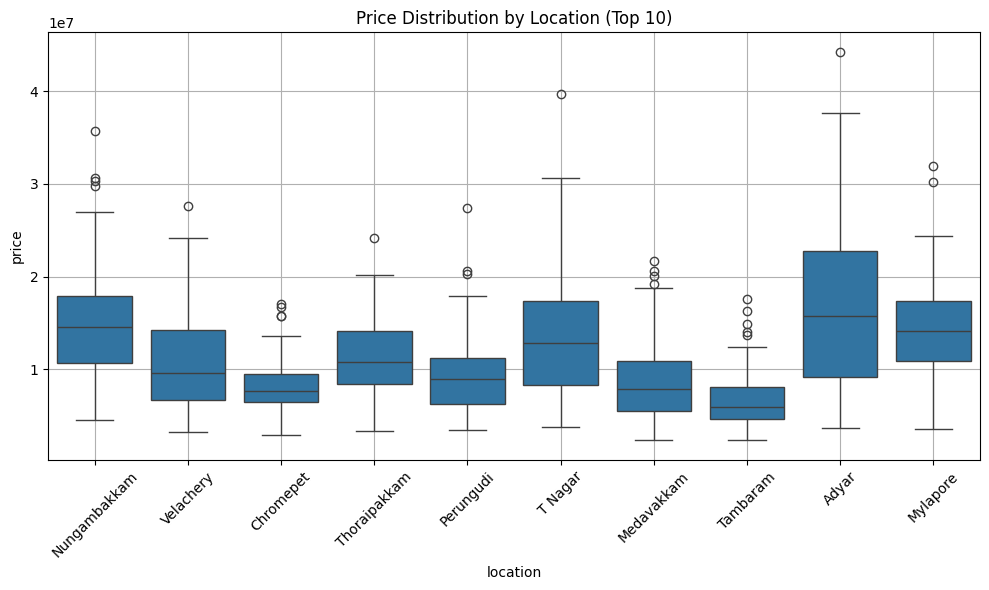

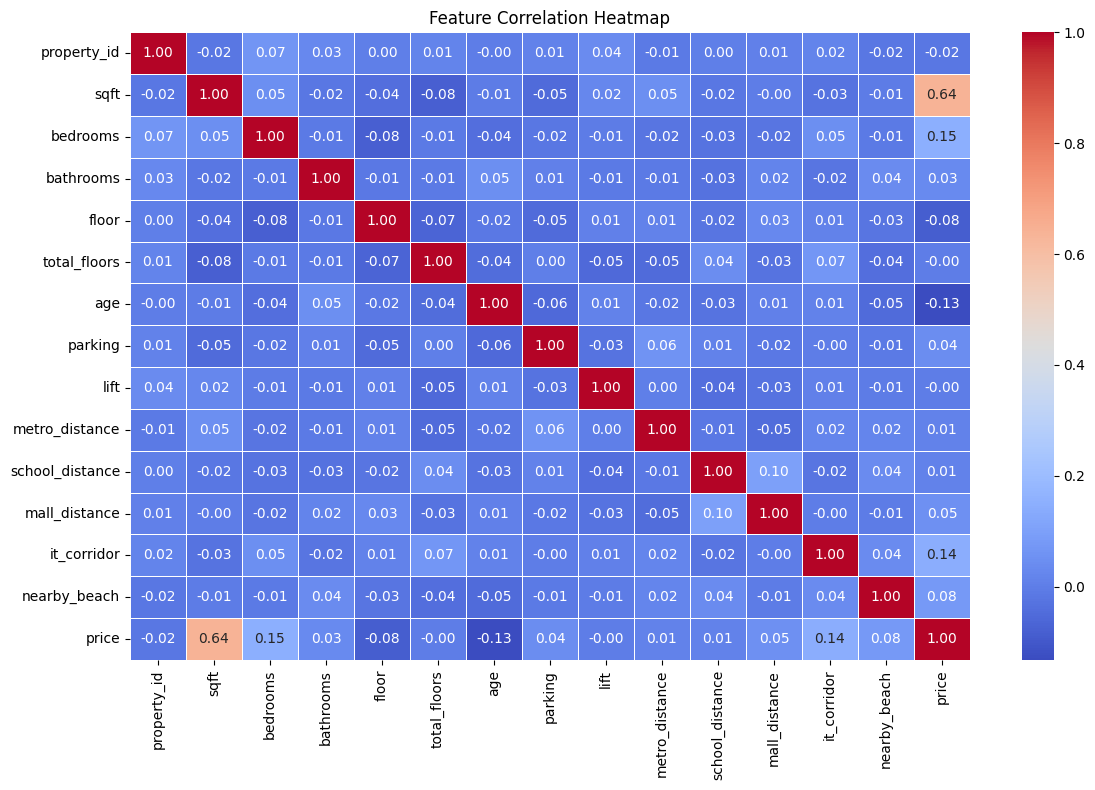

In [ ]:
#seeing what my data contain and implementing EDA to get understanding of my chennai_housing dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/chennai_housing.csv')


# it show basic information of my dataset
print("📊 Dataset Info:")
print(df.info())

# it describe basic statistics of my dataset
print("\n📈 Descriptive Statistics:")
print(df.describe())

# this function check for missing values that are been founded in my dataset
print("\n🧼 Missing Values:")
print(df.isnull().sum())

# here it Check the class distribution of categorical variables
print("\n📍 Location Distribution:")
print(df['location'].value_counts())

print("\n🏠 Property Type Distribution:")
print(df['property_type'].value_counts())

# Plotting the price distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], bins=40, kde=True, color='green')
plt.title('Distribution of Property Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot of price by property type
plt.figure(figsize=(8, 5))
sns.boxplot(x='property_type', y='price', data=df)
plt.title('Property Price by Type')
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot of price by location (note:top 10 areas only for clarity)
top_locations = df['location'].value_counts().head(10).index
plt.figure(figsize=(10, 6))
sns.boxplot(x='location', y='price', data=df[df['location'].isin(top_locations)])
plt.title('Price Distribution by Location (Top 10)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation heatmap which is important stage in EDA which show the correlation between each features
plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


In [ ]:
# here after EDA i implement Data wrangling and Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

#here i Separate features and target for features for my model
# here for independent value AKA the feature value i dropped proprty_id and price
X = df.drop(['property_id', 'price'], axis=1)
# here for dependent value AKA the target value is price which my model will predict the price
y = df['price']

# here i implemented Split data into train and test sets for improving my model performance and accuracy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define custom feature engineering without using 'price'
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Create new features that don't depend on target
        X['floor_ratio'] = X['floor'] / X['total_floors']
        X['bed_bath_ratio'] = X['bedrooms'] / X['bathrooms']
        X['amenities_score'] = X['parking'] + X['lift'] + X['it_corridor'] + X['nearby_beach']
        return X

# Define my preprocessing steps AKA numerical data
numeric_features = ['sqft', 'bedrooms', 'bathrooms', 'floor', 'total_floors','age', 'metro_distance', 'school_distance', 'mall_distance','floor_ratio', 'bed_bath_ratio', 'amenities_score']

categorical_features = ['location', 'property_type']

# Creating an separate transformers
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Full preprocessing step in pipeline
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),('cat', categorical_transformer, categorical_features)])

# Combine feature engineering with preprocessing
full_pipeline = Pipeline([('feature_engineering', FeatureEngineering()),('preprocessor', preprocessor)])

# Apply preprocessing step
X_train_processed = full_pipeline.fit_transform(X_train, y_train)
X_test_processed = full_pipeline.transform(X_test)

# Get feature names after all transformations
# For numeric features which including engineered ones
numeric_features_final = numeric_features

# here For categorical features which is after one-hot encoding
cat_encoder = full_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_features)

# here i Combine all feature names
all_features = np.concatenate([numeric_features_final, cat_features])

                            MAE           MSE          RMSE        R2
Linear Regression  1.412785e+06  3.772318e+12  1.942246e+06  0.892486
Random Forest      1.883752e+06  7.244221e+12  2.691509e+06  0.793534
Gradient Boosting  1.179162e+06  3.017855e+12  1.737197e+06  0.913989
XGBoost            1.412228e+06  4.936204e+12  2.221757e+06  0.859314


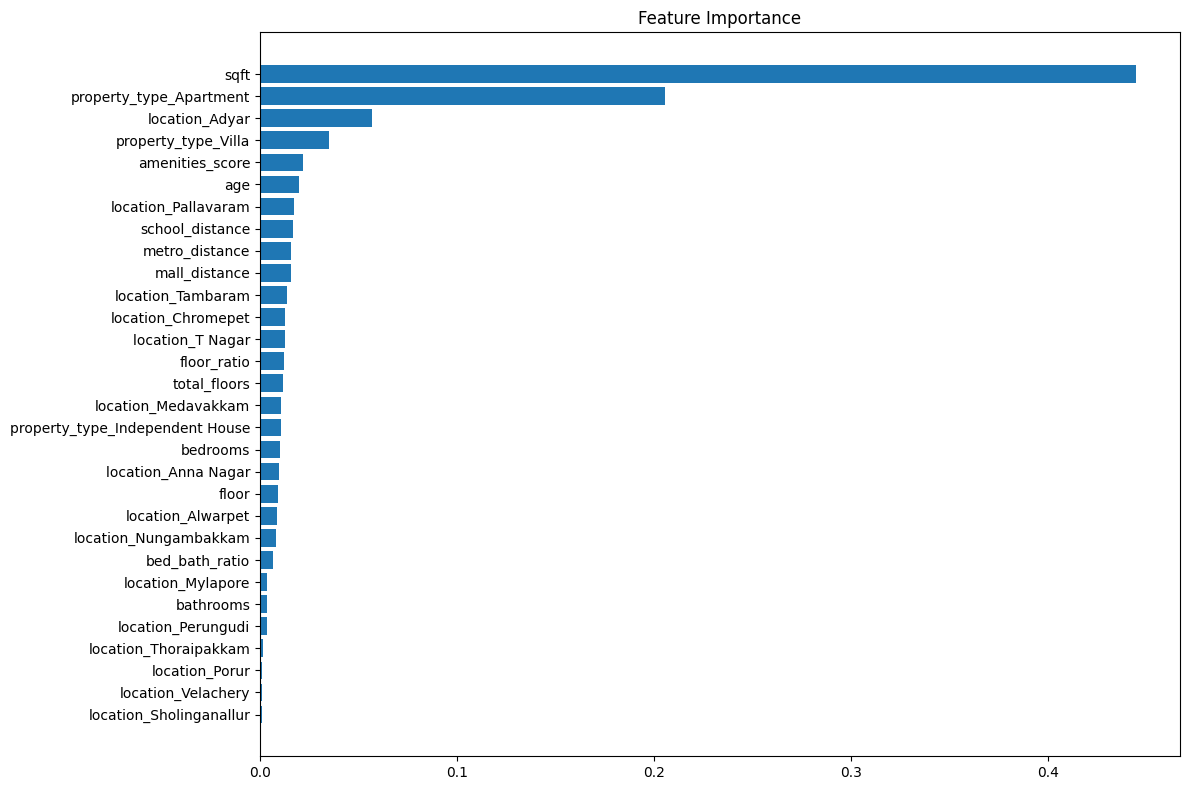

In [ ]:
#deploying predictive machine learning algorithm to my model to predict the house price
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

# Feature importance for the best model (Random Forest)
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train_processed, y_train)

# Get feature names after one-hot encoding
cat_encoder = full_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_features)
all_features = np.concatenate([numeric_features, cat_features])

# Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
importances = best_model.feature_importances_
sorted_idx = importances.argsort()
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(all_features)[sorted_idx])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [ ]:
#here i Hyperparameter Tuning(Optimizing XGBoost) for my model improvement
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)

# Perform grid search
grid_search.fit(X_train_processed, y_train)

# Get best parameters and model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# Evaluate best model
y_pred = best_rf_model.predict(X_test_processed)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {rmse}")
print(f"Best R2 Score: {r2}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE: 2689729.04274744
Best R2 Score: 0.7938068704201635


In [ ]:
import joblib
import json

# Save the best model and pipeline
joblib.dump(best_rf_model, 'best_model.pkl')
joblib.dump(full_pipeline, 'preprocessing_pipeline.pkl')

# Save feature names
with open('feature_names.json', 'w') as f:
    json.dump(list(all_features), f)

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.5 MB/s eta 0:00:00


In [ ]:
import joblib
import pandas as pd
import gradio as gr

# Load model and pipeline
model = joblib.load('best_model.pkl')
pipeline = joblib.load('preprocessing_pipeline.pkl')

# Prediction function
def predict_price(location, property_type, sqft, bedrooms, bathrooms, floor, total_floors,
                  age, parking, lift, metro_distance, school_distance, mall_distance,
                  it_corridor, nearby_beach):

    input_data = {
        'location': location,
        'property_type': property_type,
        'sqft': sqft,
        'bedrooms': bedrooms,
        'bathrooms': bathrooms,
        'floor': floor,
        'total_floors': total_floors,
        'age': age,
        'parking': parking,
        'lift': lift,
        'metro_distance': metro_distance,
        'school_distance': school_distance,
        'mall_distance': mall_distance,
        'it_corridor': it_corridor,
        'nearby_beach': nearby_beach
    }

    input_df = pd.DataFrame([input_data])
    processed = pipeline.transform(input_df)
    predicted_price = model.predict(processed)[0]
    price_per_sqft = predicted_price / sqft if sqft else 0

    result = f"🏠 **Predicted Price**: ₹{predicted_price:,.2f}\n"
    result += f"📏 **Price per Sqft**: ₹{price_per_sqft:,.2f}"

    return result

# UI with Gradio
iface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Textbox(label="Location"),
        gr.Textbox(label="Property Type"),
        gr.Number(label="Square Feet"),
        gr.Number(label="Bedrooms", precision=0),
        gr.Number(label="Bathrooms", precision=0),
        gr.Number(label="Floor", precision=0),
        gr.Number(label="Total Floors", precision=0),
        gr.Number(label="Age", precision=0),
        gr.Radio([0, 1], label="Parking (0 = No, 1 = Yes)"),
        gr.Radio([0, 1], label="Lift (0 = No, 1 = Yes)"),
        gr.Number(label="Metro Distance (km)"),
        gr.Number(label="School Distance (km)"),
        gr.Number(label="Mall Distance (km)"),
        gr.Radio([0, 1], label="IT Corridor (0 = No, 1 = Yes)"),
        gr.Radio([0, 1], label="Nearby Beach (0 = No, 1 = Yes)")
    ],
    outputs="markdown",
    title="🏠 Property Price Predictor",
    description="Enter property details to predict the expected price and price per sqft."
)

iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6279ab5145b6bc6b8b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
